# Hands-on with the U-Net

In this exercise you will take a look at a U-net architecture and will train your model with a tiny dataset. 

The objective of this exercise is not to train the best model ever, but rather to give you a feel for how the U-net model operates and how it can be applied to real-world datasets.

For this exercise the data consists is one abdominal CT scan with segmentation of the spleen. There is not quite enough to train a reasonable model, however you can play with parameters and overfit your model to this particular case so that it produces a segmentation that looks good. That is what we are going to do!

If you are feeling adventurous, and want to try and train this model for real, you can download the full spleen segmentation dataset from here: http://medicaldecathlon.com/

Below we provide some starter code and put comments prepended with TASK to indicate places where you need to fill in.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from collections import OrderedDict
import torch.optim as optim


## Constructing U-net

Below is a UNet implementation that is based on Mateusz Buda's kernel for Brain MRI Segmentation Challenge: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation 

It closely resembles the model architecture that has been presented in the original U-net paper: https://arxiv.org/pdf/1505.04597.pdf

<img src="hands-on.img/unet.png" width="600">

In [2]:
class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        # This parameter controls how far the UNet blocks grow as you go down 
        # the contracting path
        features = init_features

        # Below, we set up our layers
        self.encoder1 = self.unet_block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.unet_block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.unet_block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.unet_block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.unet_block(features * 8, features * 16, name="bottleneck")

        # Note the transposed convolutions here. These are the operations that perform
        # the upsampling. This is a blog post that explains them nicely:
        # https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = self.unet_block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = self.unet_block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = self.unet_block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = self.unet_block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
        self.softmax = nn.Softmax(dim = 1)

    # This method runs the model on a data vector. Note that this particular
    # implementation is performing 2D convolutions, therefore it is 
    # set up to deal with 2D/2.5D approaches. If you want to try out the 3D convolutions
    # from the previous exercise, you will need to modify the initialization code
    def forward(self, x):
        # Contracting/downsampling path. Each encoder here is a set of 2x convolutional layers
        # with batch normalization, followed by activation function and max pooling
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # This is the bottom-most 1-1 layer.
        # In the original paper, a dropout layer is suggested here, but
        # we won't use it here since our dataset is tiny and we basically want 
        # to overfit to it
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Expanding path. Note how output of each layer is concatenated with the downsampling block
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return self.softmax(out_conv)

    # This method executes the "U-net block"
    def unet_block(self, in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

## Loading the training data

Load training data and labels

In [3]:
training_volume = nib.load("data/spleen1_img.nii.gz").get_fdata()
training_label = nib.load("data/spleen1_label.nii.gz").get_fdata()

Let's see what we are about to segment and where's that spleen thing located:

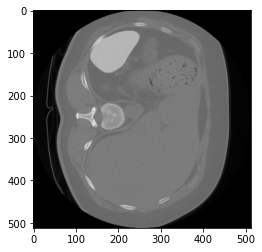

In [4]:
plt.imshow(training_volume[:,:,5] + training_label[:,:,5]*500, cmap="gray")

In [5]:
# We assume our label has one-hot encoding. Let's confirm how many distinct classes do we have in our label volume

np.unique(training_label)

array([0., 1.])

Let's set up the training device. Do we have a GPU? 

In [6]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cuda')

Instantiate the U-Net class and get it ready for training. If you want to experiment with traing hyperparameters, you can re-execute this cell to reset the model weights.

In [7]:
# Here we will use one input channel (one image at a time) and two output channels (background and label)
unet = UNet(1, 2) 

# Move all trainable parameters to the device
unet.to(device)

# We will use Cross Entropy loss function for this one - we are performing per-voxel classification task, 
# so it should do ok.
# Later in the lesson we will discuss what are some of the other options for measuring medical image 
# segmentation performance.

loss = torch.nn.CrossEntropyLoss()

# You can play with learning rate later to see what yields best results
optimizer = optim.Adam(unet.parameters(), lr=0.001)
optimizer.zero_grad()

In [8]:
# By the way, how many trainable parameters does our model have? If you will be playing 
# with 3D convolutions - compare the difference between 2D and 3D versions.

sum(p.numel() for p in unet.parameters() if p.requires_grad)

7762498

From here on let's create the training loop

## The training loop

In [9]:
%%time
# This is a basic training loop. Complete the code to run the model on first 15 slices 
# of the volume (that is where the spleen segmentation is - if you include more, you run the chances of background class
# overwhelming your tiny network with cross-entropy loss that we are using)

# Set up the model for training
unet.train()

for epoch in range(0,10):
    for slice_ix in range(0,15):
        # Let's extract the slice from the volume and convert it to tensor that the model will understand. 
        # Note that we normalize the volume to 0..1 range
        slc = training_volume[:,:,slice_ix].astype(np.single)/np.max(training_volume[:,:,slice_ix])
        
        # Our model accepts a tensor of size (batch_size, channels, w, h). We have batch of 1 and one channel, 
        # So create the missing dimensions. Also move data to our device
        slc_tensor = torch.from_numpy(slc).unsqueeze(0).unsqueeze(0).to(device)
        
        # TASK: Now extract the slice from label volume into tensor that the network will accept.
        # Keep in mind, our cross entropy loss expects integers

        # <YOUR CODE HERE>
        # ___SOLUTION
    
        lbl = training_label[:,:,slice_ix]
        lbl_tensor = torch.from_numpy(lbl).unsqueeze(0).long().to(device)
        # ___SOLUTION

        # Zero-out gradients from the previous pass so that we can start computation from scratch for this backprop run
        optimizer.zero_grad()
        
        # Do the forward pass
        pred = unet(slc_tensor)
        
        # Here we compute our loss function and do the backpropagation pass
        l = loss(pred, lbl_tensor)
        l.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch}, training loss: {l}")
        

Epoch: 0, training loss: 0.4905088543891907
Epoch: 1, training loss: 0.4324691593647003
Epoch: 2, training loss: 0.4001762270927429
Epoch: 3, training loss: 0.37997907400131226
Epoch: 4, training loss: 0.36579835414886475
Epoch: 5, training loss: 0.3561519682407379
Epoch: 6, training loss: 0.3488615155220032
Epoch: 7, training loss: 0.3436968922615051
Epoch: 8, training loss: 0.33975350856781006
Epoch: 9, training loss: 0.33667850494384766
CPU times: user 28.5 s, sys: 11.3 s, total: 39.7 s
Wall time: 39.7 s


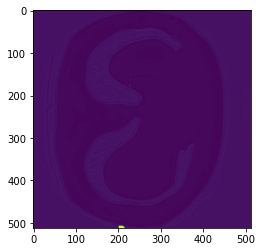

In [10]:
# Here's a neat trick: let's visualize our last network prediction with default colormap in matplotlib:
# (note the .cpu().detach() calls - we need to move our data to CPU before manipulating it and we need to 
# stop collecting the computation graph)

plt.imshow(pred.cpu().detach()[0,1])

Isn't this a nice visualization of what draws our CNN's attention after these few runs? 

Try re-executing the training cell a few times to see how this attention improves as network learns more

## Save results

Lastly, let's run inference on all slices of our volume, turn them into the binary map and save as NIFTI! We will use it in the next exercise.

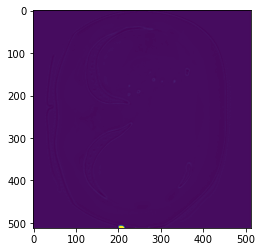

In [11]:
# Let's run inference on just one slice first

# Switch model to the eval mode so that no gradient collection happens
unet.eval()

# TASK: pick a slice from the loaded training_volume Numpy array, convert it into PyTorch tensor,
# and run an inference on it, convert result into 2D NumPy array and visualize it. 
# Don't forget to normalize your data before running inference! Also keep in mind
# that our CNN return 2 channels - one for each class - target (spleen) and background 

# <YOUR CODE HERE>
# ___SOLUTION

def inference(img):
    tsr_test = torch.from_numpy(img.astype(np.single)/np.max(img)).unsqueeze(0).unsqueeze(0)
    pred = unet(tsr_test.to(device))
    return np.squeeze(pred.cpu().detach())

level = 11

img_test = training_volume[:,:,level]
pred = inference(img_test)

plt.imshow(pred[1])
# ___SOLUTION

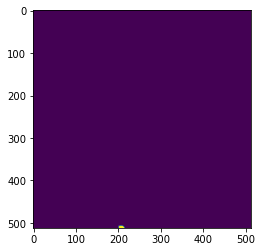

In [12]:
# Now let's convert this into binary mask using PyTorch's argmax function:

mask = torch.argmax(pred, dim=0)
plt.imshow(mask)

In [13]:
# TASK: Now you have all you need to create a full NIFTI volume. Compute segmentation predictions for each slice of your volume
# and turn them into NumPy array of the same shape as the original volume

# <YOUR CODE HERE>
# ___SOLUTION
mask3d = np.zeros(training_volume.shape)

for slc_ix in range(training_volume.shape[2]):
    pred = inference(training_volume[:,:,slc_ix])
    mask3d[:,:,slc_ix] = torch.argmax(pred, dim=0)
    
# ___SOLUTION

One thing to note here: 

Remember that [IPP/IOP](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.html) and "affine" thing I mentioned during lesson on DICOM and NIFTI file formats? Let's check it, just in case if this volume is not aligned perfectly against the coordinate axes

In [14]:
org_volume = nib.load("data/spleen1_img.nii.gz")
org_volume.affine

array([[   0.68359399,    0.        ,    0.        , -349.31652832],
       [   0.        ,    0.68359399,    0.        , -349.31652832],
       [   0.        ,    0.        ,    5.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

And it's not!

It is quite important to not forget your coordinate system transforms it when you are saving your mask if you want it to line up with your volume properly. Sometimes your affine is just an identity matrix, but sometimes (like on this volume) it's quite a bit more interesting. If you want to geek out on NIFTI affines, take a look at this: https://nipy.org/nibabel/coordinate_systems.html

In [15]:
# Finally, save our NIFTI image, copying affine from the original image

img_out = nib.Nifti1Image(mask3d, org_volume.affine)
nib.save(img_out, "data/out.nii.gz")

## Concluding remarks
Congrats, you have finished the exercise and trained your very own U-net for biomedical image segmentation!

If you want to dive deeper, here are a few suggestions:

* Try playing with the depth of UNet stacks and see how it affects your quality.
* In the last exercise you have been writing your own convolutions. Try changing the model architecture to one that that works with 2.5D or 3D convolutions.
* Later in this lesson we will talk about Dice and Jaccard similarity measures. Once you get familiar with that content, try changing the loss function and see how it affects the performance. Look up "soft dice" loss function